In [21]:
import pandas as pd
from scipy.stats import lognorm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, probplot

In [22]:
# STEP 1 : Import data
df = pd.read_csv('./historicalData/processed_btc_data.csv')
log_returns = df['log_returns'].dropna()

In [23]:
# STEP 2 : Fit distribution to the data
from scipy.stats import t

params = t.fit(log_returns)
df_t, loc_t, scale_t = params

print(f"Fitted parameters:\nDegrees of freedom (df): {df_t:.2f}\nLocation (mean): {loc_t:.5f}\nScale (std): {scale_t:.5f}")

Fitted parameters:
Degrees of freedom (df): 2.11
Location (mean): 0.00175
Scale (std): 0.01956


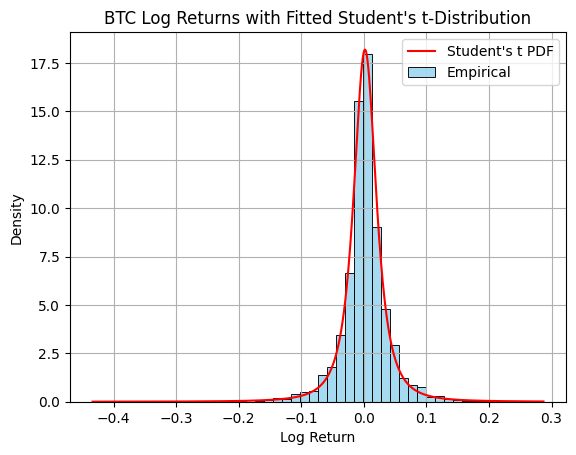

In [24]:
# STEP 2 : Empricial vs students pdf
import matplotlib.pyplot as plt
import seaborn as sns

x = np.linspace(log_returns.min(), log_returns.max(), 1000)
pdf_t = t.pdf(x, df_t, loc_t, scale_t)

sns.histplot(log_returns, bins=50, stat="density", kde=False, color="skyblue", label="Empirical")
plt.plot(x, pdf_t, 'r-', label="Student's t PDF")
plt.legend()
plt.title("BTC Log Returns with Fitted Student's t-Distribution")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.grid(True)
plt.show()

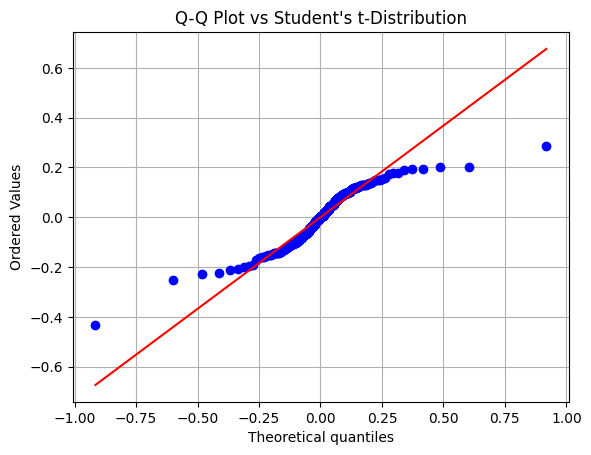

In [25]:
# STEP 2 bis: Q-Q Plot vs fitted Student's t-distribution
# Note: we use `probplot` with `dist=t` and fitted parameters
probplot(log_returns, dist=t, sparams=(df_t, loc_t, scale_t), plot=plt)
plt.title("Q-Q Plot vs Student's t-Distribution")
plt.grid(True)
plt.show()

In [29]:
# STEP 4 : KS-TEST t-distribution
from scipy.stats import kstest, t

D_stat, p_value = kstest(log_returns, 't', args=(df_t, loc_t, scale_t))
print(f"K-S Test for t-distribution: D={D_stat:.4f}, p-value={p_value:.4f}")

K-S Test for t-distribution: D=0.0228, p-value=0.0215


In [15]:
# STEP 5 : KS-TEST normal
from scipy.stats import norm

# Fit normal distribution
params_norm = norm.fit(log_returns)
D_norm, p_norm = kstest(log_returns, 'norm', args=params_norm)
print(f"K-S Test for normal: D={D_norm:.4f}, p-value={p_norm:.4f}")

K-S Test for normal: D=0.1068, p-value=0.0000


In [7]:
#Even though the t-distribution is not a perfect fit, it performs better than the normal, 
#which is commonly assumed but clearly inappropriate for BTC returns.

In [16]:
# STEP 4: Bootstrap

from tqdm import tqdm  

n = len(log_returns)
n_bootstraps = 1000
D_boot = []

for _ in tqdm(range(n_bootstraps)):
    # Step 4.1: Generate synthetic sample from fitted t-distribution of size n
    sample = t.rvs(df_t, loc=loc_t, scale=scale_t, size=n)

    # Step 4.2: Fit t-distribution to synthetic sample
    df_b, loc_b, scale_b = t.fit(sample)

    # Step 4.3: Compute K-S statistic on the bootstrap sample
    D_b, _ = kstest(sample, 't', args=(df_b, loc_b, scale_b))
    D_boot.append(D_b)

100%|██████████████████████████████████████████████████████████████████| 1000/1000 [00:41<00:00, 24.33it/s]


In [17]:
# STEP 5: Compute the empirical p-value
D_boot = np.array(D_boot)
p_value_bootstrap = np.mean(D_boot >= D_stat)

print(f"\nBootstrap p-value: {p_value_bootstrap:.5f}")


Bootstrap p-value: 0.00500
